In [1]:
%pip install catboost joblib
%pip install shap

import os
import pandas as pd
import numpy as np
import joblib
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from datetime import datetime
import json

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def evaluate(y_true, y_pred, results, solver_name, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    rel_rmse = rmse / np.mean(y_true)

    safe_y_true = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / safe_y_true)) * 100

    result = {
        "Solver": solver_name,
        "Dataset": label,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Rel_RMSE": rel_rmse,
        "MAPE (%)": mape,
    }
    results.append(result)

In [ ]:
def train_catboost_for_solver(solver_name, train_file, test_file, val_file):
    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)
    df_val = pd.read_csv(val_file)

    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    df_val.dropna(inplace=True)

    target_cols = ["solution_time", "optimality_gap", "peak_memory"]
    features = [
        "number_of_elements", "capacity", "max_weight", "min_weight", "mean_weight",
        "median_weight", "std_weight", "weight_range", "max_profit", "min_profit", "mean_profit",
        "median_profit", "std_profit", "profit_range", "renting_ratio", "mean_weight_profit_ratio",
        "median_weight_profit_ratio", "capacity_mean_weight_ratio", "capacity_median_weight_ratio",
        "capacity_std_weight_ratio", "std_weight_profit_ratio", "weight_profit_correlation", "ram", "cpu_cores"
    ]

    for df in [df_train, df_test, df_val]:
        for col in target_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=[col], inplace=True)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[features])
    X_test = scaler.transform(df_test[features])
    X_val = scaler.transform(df_val[features])

    os.makedirs("./results/cb/cb_tuning", exist_ok=True)
    os.makedirs("./results/cb/cb_configs", exist_ok=True)
    os.makedirs("./results/cb/cb_shap", exist_ok=True)
    os.makedirs("./results/cb/cb_feature_importance", exist_ok=True)

    results = []

    for target in target_cols:
        if df_train[target].nunique() <= 1:
            print(f"Skipping training for '{solver_name}' — target '{target}' has constant values.")
            continue

        y_train = df_train[target].values
        y_test = df_test[target].values
        y_val = df_val[target].values

        # Hyperparameter grid
        param_grid = [
            {"iterations": i, "depth": d, "learning_rate": lr}
            for i in [500]
            for d in [6, 8]
            for lr in [0.01, 0.05, 0.1]
        ]

        best_rmse = float("inf")
        best_model = None
        best_config = None
        tuning_logs = []

        for params in param_grid:
            model = CatBoostRegressor(
                iterations=params["iterations"],
                depth=params["depth"],
                learning_rate=params["learning_rate"],
                loss_function="RMSE",
                verbose=False,
                random_seed=42
            )
            model.fit(X_train, y_train)
            pred_val = model.predict(X_val)
            mse = mean_squared_error(y_val, pred_val)
            rmse = np.sqrt(mse)
            tuning_logs.append({**params, "rmse": rmse})

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_config = params
                best_pred_test = model.predict(X_test)
                best_pred_val = pred_val

        # Save tuning results and best config
        pd.DataFrame(tuning_logs).to_csv(
            f"./results/cb/cb_tuning/tuning_cb_{solver_name}_{target}_reg.csv", index=False
        )
        with open(f"./results/cb/cb_configs/best_cb_{solver_name}_{target}_reg.json", "w") as f:
            json.dump(best_config, f, indent=4)
            
        
        # Save CatBoost Model
        os.makedirs("./results/cb_models", exist_ok=True)
        model_path = f"./results/cb_models/cb_model_{solver_name}_{target}.cbm"
        best_model.save_model(model_path)
        print(f"Saved CatBoost model to {model_path}")

        # SHAP values
        catboost_pool_val = Pool(X_val, label=y_val, feature_names=features)
        shap_values = best_model.get_feature_importance(type='ShapValues', data=catboost_pool_val)
        shap_df = pd.DataFrame(shap_values[:, :-1], columns=features)
        shap_df["expected_value"] = shap_values[:, -1]
        shap_df["predicted_value"] = best_pred_val
        shap_df["actual_value"] = y_val
        shap_df["target"] = target
        shap_df["solver"] = solver_name
        shap.summary_plot(shap_values[:, :-1], X_val, feature_names=features, show=False)
        shap_df.to_csv(f"./results/cb/cb_shap/shap_{solver_name}_{target}_reg.csv", index=False)

        # Feature importance
        importances = best_model.get_feature_importance()
        feature_importance_df = pd.DataFrame({
            "feature": features,
            "importance": importances,
            "target": target,
            "solver": solver_name
        })

        feature_importance_file = "./results/cb/cb_feature_importance/catboost_feature_importance_reg.csv"
        top5_file = "./results/cb/cb_feature_importance/catboost_top5_feature_importance_reg.csv"

        if os.path.exists(feature_importance_file):
            feature_importance_df.to_csv(feature_importance_file, mode='a', index=False, header=False)
        else:
            feature_importance_df.to_csv(feature_importance_file, index=False)

        feature_importance_df.sort_values(by="importance", ascending=False).head(5).to_csv(
            top5_file, mode='a', index=False, header=not os.path.exists(top5_file)
        )

        print(f"Target: {target.upper()} | Best Params: {best_config}")
        print(" TEST")
        evaluate(y_test, best_pred_test, results, solver_name, label=f"{target} (Test)")
        print("VAL")
        evaluate(y_val, best_pred_val, results, solver_name, label=f"{target} (Val)")

    results_df = pd.DataFrame(results)
    results_file = "./results/catboost_evaluation_results.csv"
    results_df.to_csv(results_file, mode='a', index=False, header=not os.path.exists(results_file))

In [7]:
def run_all_models(base_folder):
    for root, dirs, files in os.walk(base_folder):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            csv_files = os.listdir(folder_path)

            train_file = [f for f in csv_files if f.endswith("_train.csv")]
            test_file = [f for f in csv_files if f.endswith("_test.csv")]
            val_file = [f for f in csv_files if f.endswith("_val.csv")]

            if train_file and test_file and val_file:
                train_fp = os.path.join(folder_path, train_file[0])
                test_fp = os.path.join(folder_path, test_file[0])
                val_fp = os.path.join(folder_path, val_file[0])

                solver_name = folder  # name of the subfolder
                train_catboost_for_solver(solver_name, train_fp, test_fp, val_fp)

Saved CatBoost model to ./results_min_kp/cb_models/cb_model_or_min_solution_time.cbm
Target: SOLUTION_TIME | Best Params: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}
 TEST
VAL
Saved CatBoost model to ./results_min_kp/cb_models/cb_model_or_min_optimality_gap.cbm
Target: OPTIMALITY_GAP | Best Params: {'iterations': 500, 'depth': 6, 'learning_rate': 0.01}
 TEST
VAL
Saved CatBoost model to ./results_min_kp/cb_models/cb_model_or_min_peak_memory.cbm
Target: PEAK_MEMORY | Best Params: {'iterations': 500, 'depth': 8, 'learning_rate': 0.01}
 TEST
VAL
Saved CatBoost model to ./results_min_kp/cb_models/cb_model_gurobi_min_solution_time.cbm
Target: SOLUTION_TIME | Best Params: {'iterations': 500, 'depth': 8, 'learning_rate': 0.01}
 TEST
VAL
Skipping training for 'gurobi_min' — target 'optimality_gap' has constant values.
Saved CatBoost model to ./results_min_kp/cb_models/cb_model_gurobi_min_peak_memory.cbm
Target: PEAK_MEMORY | Best Params: {'iterations': 500, 'depth': 8, 'learning_rate'

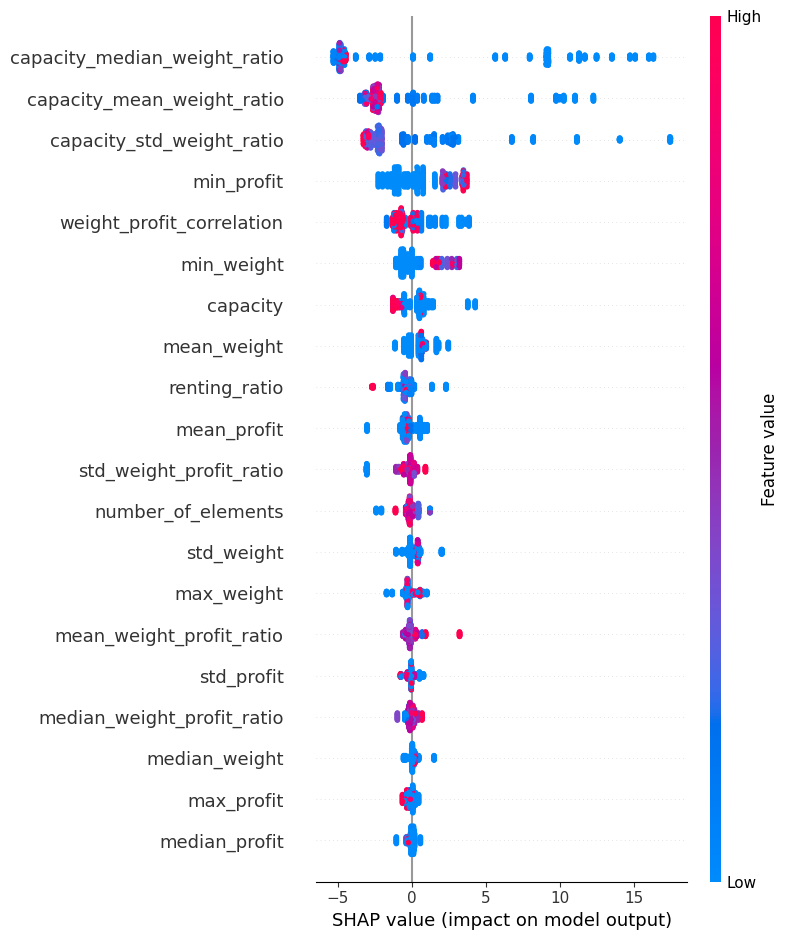

In [ ]:
base_folder = "./trainingData/final_td_min"  #Specify the folder path where the training data is saved
run_all_models(base_folder)